# Mid-Sagittal plane algorithm

### Import relevant packages

In [439]:
import os
import time
import gzip

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio

import nibabel as nib
from nibabel.orientations import aff2axcodes

import joblib

from scipy.ndimage import center_of_mass, find_objects
from scipy.optimize import minimize
from scipy.interpolate import RegularGridInterpolator

import ipywidgets as widgets
from matplotlib.lines import Line2D

## Data Reading

In [ ]:
def load_nifti_file(file_path):
    

    nifti_img = nib.load(file_path)
    data = nifti_img.get_fdata()
    voxel_size = np.array(nifti_img.header.get_zooms())

    # determine which data-axis is world-X, world-Y, world-Z
    codes = aff2axcodes(nifti_img.affine)  
    code2world = {'L':0,'R':0,'P':1,'A':1,'I':2,'S':2}
    world_of_axis = [code2world[c] for c in codes]  
    # find data-axis indices for each world axis
    idx_x = world_of_axis.index(0)  # sagittal
    idx_y = world_of_axis.index(1)  # coronal
    idx_z = world_of_axis.index(2)  # axial

    # we want new_data[ coronal, sagittal, axial ]
    new_order = [idx_y, idx_x, idx_z]
    data = np.transpose(data, new_order)
    voxel_size = np.array(tuple(voxel_size[new_order]))

    return data, voxel_size

def open_gzip_file(gzip_file_path):
    """
    Open a gzip file and return its content.

    Parameters:
    gzip_file_path (str): The path to the gzip file.

    Returns:
    bytes: The content of the gzip file.
    """
    try:
        with gzip.open(gzip_file_path, 'rb') as f_in:
            file_content = f_in.read()
        return file_content
    except Exception as e:
        print(f'Error opening {gzip_file_path}: {e}')
        return None
    
def get_image_and_voxel_size_from_gzip(gzip_file_path):
    """
    Get the image array and voxel size from a gzipped NIfTI file.

    Parameters:
    gzip_file_path (str): Path to the gzipped NIfTI file.

    Returns:
    tuple: The image array and voxel size.
    """

    file_content = open_gzip_file(gzip_file_path)
    if file_content is not None:
        with open('temp_nifti.nii', 'wb') as temp_file:
            temp_file.write(file_content)

        # 🔹 Debugging: Check if the file was actually written
        file_size = os.path.getsize('temp_nifti.nii')
        if file_size == 0:
            print(f"❌ Error: 'temp_nifti.nii' was written but is empty! ({gzip_file_path})")
            return None, None

        img_data, voxel_size = load_nifti_file('temp_nifti.nii')
        os.remove('temp_nifti.nii')  # Remove temp file after reading
        
        return img_data, voxel_size
    else:
        print(f"❌ Error: Failed to read file content from '{gzip_file_path}'")
        return None, None
    
def load_patient_structures(patient_folder: str, structure_names=None):
    
    if structure_names is None:
        structure_names = ['Image']

    struct_dict = {}
    for root, _, files in os.walk(patient_folder):
        for f in files:
            # Only NIfTI files
            if not (f.endswith('.nii.gz') or f.endswith('.nii')):
                continue

            name_part = f
            
            # Entferne Extension
            if name_part.endswith('.nii.gz'):
                base = name_part[:-7]
            else:
                base = name_part[:-4]

            # Vergleiche mit erwarteten Struktur-Namen (case-insensitive)
            for struct_name in structure_names:
                if base.lower() == struct_name.lower():
                    file_path = os.path.join(root, f)
                    try:
                        if f.endswith('.nii.gz'):
                            img, voxel_size = get_image_and_voxel_size_from_gzip(file_path)
                        else:
                            img, voxel_size = load_nifti_file(file_path)
                    except Exception as e:
                        logging.error(f"Error loading '{struct_name}' from {file_path}: {e}")
                        continue

                    if img is not None:
                        struct_dict[struct_name] = (img, voxel_size)
                        print(f"Loaded '{struct_name}' from {file_path}")
                    break
    return struct_dict

## Image processing

In [441]:
def mask_via_threshold(ct_image, HU_range=(300, 1500)):
    
    bone_mask = np.zeros_like(ct_image)
    lower_bound, upper_bound = HU_range
    bone_mask[(ct_image >= lower_bound) & (ct_image <= upper_bound)] = 1

    return bone_mask

def crop_patient_volumes(struct_dict,
                         slice_axis=2,
                         slice_range=None):

    image = struct_dict['Image'][0]
    if 'GTVp' in struct_dict:
        gtvp = struct_dict['GTVp'][0]
        slc = find_objects(gtvp.astype(bool))[0]
        start, end = slc[slice_axis].start, slc[slice_axis].stop - 1
    elif slice_range is not None:
        start, end = slice_range
    else:
        start, end = 0, image.shape[slice_axis] - 1

    idx = np.arange(start, end + 1)

    def _crop(arr):
        return np.take(arr, idx, axis=slice_axis)

    for structure in struct_dict:
        struct_dict[structure] = _crop(struct_dict[structure][0])

    return struct_dict

def preprocess_bone_image(struct_dict,
                          HU_range,
                          ):
    
    proc_image = struct_dict['Image'].astype(np.int16)

    if 'Body' in struct_dict:
        body = struct_dict['Body']
        proc_image = np.where(body == 1, proc_image, np.min(proc_image))

    bone_mask = mask_via_threshold(proc_image, HU_range).astype(np.uint16)
    bone_ct = proc_image * bone_mask

    return proc_image, bone_ct


## Interpolation

In [442]:
def get_cached_interpolator(output_dir,
                            image,
                            voxel_size,
                            filename='interpolator.joblib',
                            method='cubic'):
    """
    Load—or if missing, build and cache—a RegularGridInterpolator
    on the physical coordinate grid defined by voxel_size.

    Parameters
    ----------
    output_dir : str
        Directory in which to look for / save the cached interpolator.
    image : ndarray, shape (Ny, Nx, Nz)
        Reoriented volume data.
    voxel_size : sequence of 3 floats
        Physical spacing in mm along (Y, X, Z) axes.
    filename : str, optional
        Name of the .joblib file to load/save under output_dir.
    method : str, optional
        Interpolation method: ‘cubic’, ‘linear’, etc.

    Returns
    -------
    interpolator : RegularGridInterpolator
        Maps (y_mm, x_mm, z_mm) → image intensity.
    """
    os.makedirs(output_dir, exist_ok=True)
    interpolator_path = os.path.join(output_dir, filename)

    # build physical‐space sample grids
    Ny, Nx, Nz = image.shape
    grid_y = np.arange(Ny) * voxel_size[0]
    grid_x = np.arange(Nx) * voxel_size[1]
    grid_z = np.arange(Nz) * voxel_size[2]

    if os.path.exists(interpolator_path):
        interpolator = joblib.load(interpolator_path)
    else:
        start = time.time()
        interpolator = RegularGridInterpolator(
            (grid_y, grid_x, grid_z),
            image,
            method=method,
            bounds_error=False,
            fill_value=None
        )
        elapsed = time.time() - start
        print(f"Cubic interpolator built in {elapsed:.2f}s and cached to\n  {interpolator_path}")
        joblib.dump(interpolator, interpolator_path)

    return interpolator


## Parametrization

In [443]:
def vector_to_angles(vector):
    
    x, y, z = vector

    # Calculate the distance from the origin
    R = np.linalg.norm(vector)

    # Calculate the distance from the origin in xy plane
    r = np.sqrt(x**2 + y**2)

    # Calculate the angle in the xy plane with respect to the x-axis
    azimuthal = np.arctan2(y, x)

    # Calculate the angle in the xz plane with respect to the z-axis
    polar = np.arctan2(r, z)

    return np.array([azimuthal, polar, R])

def angles_to_vector(azimuthal, polar, R):
    
    x = R * np.sin(polar) * np.cos(azimuthal)
    y = R * np.sin(polar) * np.sin(azimuthal)
    z = R * np.cos(polar)
    
    return np.array([x, y, z])

def generate_normal(theta: float, phi: float) -> np.ndarray:
    return np.array([
        np.sin(phi) * np.cos(theta),
        np.sin(phi) * np.sin(theta),
        np.cos(phi)
    ])

## Objective function


In [444]:
def compute_signed_distances(params_array, image, voxel_size):
    
    azimuthal, polar, L = params_array

    indices_image = np.array(np.nonzero(image)).T

    indices_image_phy = indices_image * voxel_size

    indices_coord_syst_phy = np.stack([
        indices_image_phy[:,1],
        indices_image_phy[:,0],
        indices_image_phy[:,2]
    ], axis=1)

    n = generate_normal(azimuthal, polar)

    d = indices_coord_syst_phy.dot(n) - L

    return d, n, indices_coord_syst_phy, indices_image

def huber_loss_function(diff, delta=300):
    
    h_loss = np.where(np.abs(diff) <= delta, 0.5 * diff**2,
                    delta * (np.abs(diff) - 0.5 * delta))
    return h_loss


def compute_objective(params_array, bone, interpolator_intensity, voxel_size, delta):
    
    d, n, indices_coord_syst_phy, indices_image = compute_signed_distances(params_array, bone, voxel_size)
    x_m_coord_syst_phy = indices_coord_syst_phy - 2 * d[:, None] * n[None, :]
    x_m_image_phy = np.array([x_m_coord_syst_phy[:, 1], x_m_coord_syst_phy[:, 0], x_m_coord_syst_phy[:, 2]]).T
    I_m = interpolator_intensity(x_m_image_phy)
    I_orig = bone[indices_image[:, 0], indices_image[:, 1], indices_image[:, 2]]
    diff = I_orig - I_m
    f = np.sum(huber_loss_function(diff, delta=delta)).mean()
    return f



## Parameter Initialization

In [445]:
def parameter_initialization(image, bone, output_path, interpolator_intensity, voxel_size, delta,
                         azimuthal_deg_range=(0,90), polar_deg_range=(90,10),
                         initialization_steps=10):
    start = time.time()
    com_phy = center_of_mass(image) * voxel_size
    com_coords_phy = np.array([com_phy[1], com_phy[0], com_phy[2]])
   
    # Define angular search ranges (in radians)
    azimuthal_rad, delta_azimuthal_rad = np.deg2rad(azimuthal_deg_range)
    polar_rad, delta_polar_rad = np.deg2rad(polar_deg_range)
    azimuthal_angles = np.linspace(azimuthal_rad - delta_azimuthal_rad, azimuthal_rad + delta_azimuthal_rad, initialization_steps)
    polar_angles = np.linspace(polar_rad - delta_polar_rad, polar_rad + delta_polar_rad, initialization_steps)
    os.makedirs(output_path, exist_ok=True)
    mse_array_file = os.path.join(output_path, f"Initialization_obj_fun.npy")
    plane_params_file = os.path.join(output_path, f"Initialization_plane_params.npy")
    
    if not (os.path.exists(mse_array_file) and os.path.exists(plane_params_file)):
        print("Starting parameter initialization...")
        θ, φ = np.meshgrid(azimuthal_angles, polar_angles, indexing='ij')
        n = generate_normal(θ, φ)
        L = np.tensordot(n, com_coords_phy, axes=([0],[0]))
        planes = np.stack([θ.ravel(), φ.ravel(), L.ravel()], axis=1)
        mse_array = np.array([compute_objective(p, bone, interpolator_intensity, voxel_size, delta) for p in planes])
        np.save(mse_array_file, mse_array)
        np.save(plane_params_file, planes)
        end = time.time()
        print(f"Time taken for initialization: {end - start:.2f} seconds")
    else:
        mse_array = np.load(mse_array_file)
        planes    = np.load(plane_params_file)
    best_mse_index = np.argmin(mse_array)
    best_params = planes[best_mse_index]
    plot_mse_heatmap(azimuthal_angles, polar_angles, mse_array, 
                     title=f"MSE Heatmap over (θ, φ) grid with optimum at:\nθ = {np.rad2deg(best_params[0]):.2f}° φ = {np.rad2deg(best_params[1]):.2f}° L = {best_params[2]:.2f}\nwith MSE = {mse_array[best_mse_index]:.2f}",
                     output_path=output_path)
    return best_params

def plot_mse_heatmap(azimuthal_angles, polar_angles, mse_array, title="MSE Heatmap", output_path=None):
    
    P = len(polar_angles)
    T = len(azimuthal_angles)

    mse_2d = mse_array.reshape(P, T)

    theta_deg = np.rad2deg(azimuthal_angles)
    phi_deg   = np.rad2deg(polar_angles)

    TH, PH = np.meshgrid(theta_deg, phi_deg)
    plt.figure(figsize=(8, 6))
    plt.pcolormesh(TH, PH, mse_2d, shading='auto', cmap='viridis', vmin = np.min(mse_2d) , vmax = np.min(mse_2d) + 100000)
    plt.colorbar(label='MSE')
    plt.xlabel('Azimuthal angle θ (°)')
    plt.ylabel('Polar angle φ (°)')
    plt.title(title)
    plt.grid(visible=True, linestyle='--', alpha=0.7)
    if output_path is not None:
        plt.savefig(os.path.join(output_path, "mse_heatmap.png"), dpi=300)

## Optimization

In [446]:
def optimize_plane(initial_params_array, image, interpolator_intensity, voxel_size, delta):

    objective_value_list = []
    params_list = []

    def callback(xk):
        f_val = compute_objective(xk, image, interpolator_intensity, voxel_size, delta)
        objective_value_list.append(f_val)
        params_list.append(xk.copy())

    res = minimize(compute_objective, x0=initial_params_array, args=(image, interpolator_intensity, voxel_size, delta),
                   method='BFGS', jac=None, callback=callback)
    params_list.append(res.x.copy())
    objective_value_list.append(res.fun)

    res.objective_value_list = objective_value_list
    res.params_list = params_list

    return res

def run_or_load_optimization(output_path_patient,
                             image,
                             voxel_size_image,
                             delta,
                             initial_plane,
                             bone_ct,
                             interpolator,
                             optimized_parameter_list,
                             optimized_objective_value_list):
    
    param_path = os.path.join(output_path_patient, "parameter_array.npy")
    obj_path   = os.path.join(output_path_patient, "objective_value_array.npy")

    if os.path.exists(param_path) and os.path.exists(obj_path):
        # load the last saved result
        params_arr = np.load(param_path)
        obj_arr    = np.load(obj_path)
        optimized_parameters      = params_arr[-1]
        optimized_objective_value = obj_arr[-1]
        print(f"Optimized parameters: "
              f"{np.rad2deg(optimized_parameters[0]):.2f}°, "
              f"{np.rad2deg(optimized_parameters[1]):.2f}°, "
              f"{optimized_parameters[2]:.2f} mm "
              f"with MSE {optimized_objective_value:.2f}") 
        make_plane_gif(image, voxel_size_image, params_arr, obj_arr, output_path_patient)
    else:
        start = time.time()
        res = optimize_plane(initial_plane,
                             bone_ct,
                             interpolator,
                             voxel_size_image,
                             delta)
        end = time.time()
        print(f"Optimization took {end - start:.2f} seconds.")

        optimized_parameters      = res.x
        optimized_objective_value = res.fun
        print(f"Optimized parameters: "
              f"{np.rad2deg(optimized_parameters[0]):.2f}°, "
              f"{np.rad2deg(optimized_parameters[1]):.2f}°, "
              f"{optimized_parameters[2]:.2f} mm "
              f"with MSE {optimized_objective_value:.2f}")
        
        make_plane_gif(image, voxel_size_image, np.array(res.params_list), np.array(res.objective_value_list), output_path_patient)
        np.save(param_path,   np.array(res.params_list))
        np.save(obj_path,     np.array(res.objective_value_list))

        optimized_parameter_list.append(optimized_parameters)
        optimized_objective_value_list.append(optimized_objective_value)

    return optimized_parameters, optimized_objective_value



## Optimization visualization


In [447]:
def make_plane_gif(image_3d, voxel_size, plane_params, objective_values, output_path, duration=2):
    """
    Creates a GIF showing successive plane contours on the middle slice of a 3D image,
    with axes in millimetres.

    Parameters
    ----------
    image_3d : ndarray, shape (H, W, D)
        Re-oriented volume data (coronal, sagittal, axial).
    voxel_size : tuple(float, float, float)
        Spacing in mm along (coronal=y, sagittal=x, axial=z).
    plane_params_list : array-like of shape (N,3)
        Each row = (theta, phi, L_mm) in radians and offset in mm.
    output_path : str
        Path (including filename) to save the resulting GIF (e.g. 'planes.gif').
    duration : float
        Time in seconds each frame is shown.
    """
    H, W, D = image_3d.shape
    sy, sx, sz = voxel_size

    # middle slice and its physical z
    z0 = D // 2
    z0_mm = z0 * sz
    slice_img = image_3d[:, :, z0]

    # physical grid for contour
    y_mm = np.arange(H) * sy
    x_mm = np.arange(W) * sx
    X_mm, Y_mm = np.meshgrid(x_mm, y_mm)  # note: meshgrid(x,y) -> X shape (len(y), len(x))

    writer = imageio.get_writer(os.path.join(output_path, "plane_optimization.gif"), mode='I', duration=duration)

    for idx in range(plane_params.shape[0]):
        # extract parameters
        theta, phi, L_mm = plane_params[idx]
        objective_value = objective_values[idx]
        # compute plane normal
        n = np.array([
            np.sin(phi) * np.cos(theta),
            np.sin(phi) * np.sin(theta),
            np.cos(phi)
        ])
        nx, ny, nz = n

        # plane constant
        C = L_mm - nz * z0_mm

        # contour function in mm
        F = nx * X_mm + ny * Y_mm - C

        # plot
        fig = plt.figure(figsize=(6,6))
        canvas = FigureCanvas(fig)
        ax = fig.add_subplot(111)
        ax.imshow(slice_img,
                  cmap='gray',
                  origin='lower',
                  extent=[x_mm[0], x_mm[-1], y_mm[0], y_mm[-1]])
        ax.contour(X_mm, Y_mm, F, levels=[0], colors='red')
        ax.set_title(f'Plane {idx+1}: θ={np.rad2deg(theta):.1f}°, '
                     f'φ={np.rad2deg(phi):.1f}°, L={L_mm:.1f} mm\nMSE={objective_value:.2f}')
        ax.set_xlabel('x (mm)')
        ax.set_ylabel('y (mm)')
        #ax.axis('off')

        # render to image
        canvas.draw()
        buf, (w, h) = canvas.print_to_buffer()
        frame = np.frombuffer(buf, dtype='uint8').reshape(h, w, 4)[..., :3]
        writer.append_data(frame)

        plt.close(fig)

    writer.close()
    print(f"Saved GIF to {output_path}")


## Scrollable Widget

In [448]:
def display_scrollable_views(
        struct_dict: dict,
        voxel_size,
        plane_coeffs_list=None,
        optimization_methods_list=None,
):
    """
    Interactive axial + coronal viewer with structure contours and symmetry planes.

    - Axial: rows=Y, cols=X at fixed Z-slice.
    - Coronal: rows=Z, cols=X at fixed Y-slice.
    """
    if plane_coeffs_list is None:
        plane_coeffs_list = []
    if optimization_methods_list is None:
        optimization_methods_list = []

    def _array(obj):
        return obj[0] if isinstance(obj, (tuple, list)) else obj

    image = _array(struct_dict['Image'])
    H, W, D = image.shape
    sy, sx, sz = voxel_size

    # physical axes
    y_mm = np.arange(H) * sy
    x_mm = np.arange(W) * sx
    z_mm = np.arange(D) * sz

    # precompute meshgrids
    X_ax, Y_ax = np.meshgrid(x_mm, y_mm)   # for axial view
    X_cor, Z_cor = np.meshgrid(x_mm, z_mm) # for coronal view

    # colors
    plane_colors = ['red','purple','cyan','lime','magenta']
    struct_names = [s for s in struct_dict if s != 'Image']
    cmap10 = plt.cm.get_cmap('tab10').colors
    color_cycle = {n: cmap10[i] for i,n in enumerate(struct_names)}

    def view_slice_axial(z_index:int, y_line:int):
        fig, ax = plt.subplots(1,2, figsize=(12,6), constrained_layout=True)
        # --- Axial ---
        ax0 = ax[0]
        ax0.imshow(image[:,:,z_index], cmap='gray',
                   extent=[x_mm[0],x_mm[-1],y_mm[-1],y_mm[0]])
        ax0.set_title(f'Axial z={z_index} (z={z_index*sz:.1f} mm)')
        ax0.set_xlabel('X (sagittal) mm'); ax0.set_ylabel('Y (coronal) mm')
        # horizontal guide at Y = y_line
        y0 = y_mm[y_line]
        ax0.axhline(y=y0, color='yellow', linestyle='--')
        # structure contours
        for name in struct_names:
            mask = _array(struct_dict[name])
            sl = mask[:,:,z_index]
            if sl.any():
                ax0.contour(X_ax, Y_ax, sl, colors=[color_cycle[name]], linewidths=1)
        # planes
        for i,(theta,phi,L) in enumerate(plane_coeffs_list):
            nx = np.sin(phi)*np.cos(theta)
            ny = np.sin(phi)*np.sin(theta)
            nz = np.cos(phi)
            C = L - nz*(z_index*sz)
            F = nx*X_ax + ny*Y_ax - C
            ax0.contour(X_ax, Y_ax, F, levels=[0],
                        colors=[plane_colors[i%len(plane_colors)]], linewidths=1)
        # legend
        handles=[]
        for n in struct_names:
            handles.append(Line2D([0],[0],color=color_cycle[n],lw=2,label=n))
        for i,method in enumerate(optimization_methods_list):
            handles.append(Line2D([0],[0],color=plane_colors[i%len(plane_colors)],
                                  lw=2,label=method))
        ax0.legend(handles=handles, loc='upper right')

        # --- Coronal ---
        ax1 = ax[1]
        sl = image[y_line,:,:].T
        ax1.imshow(sl, cmap='gray', origin='upper',
                   extent=[x_mm[0],x_mm[-1],z_mm[-1],z_mm[0]])
        ax1.set_title(f'Coronal y={y_line} (y={y_line*sy:.1f} mm)')
        ax1.set_xlabel('X (sagittal) mm'); ax1.set_ylabel('Z (axial) mm')
        # vertical guide at Z = z_index
        z0 = z_mm[z_index]
        ax1.axhline(y=z0, color='yellow', linestyle='--')
        # structure contours
        for name in struct_names:
            mask = _array(struct_dict[name])
            slm = mask[y_line,:,:].T
            if slm.any():
                ax1.contour(X_cor, Z_cor, slm,
                            colors=[color_cycle[name]], linewidths=1)
        # planes
        y0 = y_line * sy
        for i,(theta,phi,L) in enumerate(plane_coeffs_list):
            nx = np.sin(phi)*np.cos(theta)
            ny = np.sin(phi)*np.sin(theta)
            nz = np.cos(phi)
            F = nx*X_cor + ny*y0 + nz*Z_cor - L
            ax1.contour(X_cor, Z_cor, F, levels=[0],
                        colors=[plane_colors[i%len(plane_colors)]], linewidths=1)

        plt.show()

    # interactive sliders for Z (axial) and Y (coronal)
    widgets.interact(
        view_slice_axial,
        z_index = widgets.IntSlider(min=0, max=D-1, step=1, value=D//2,
                                    description='Z slice', continuous_update=False),
        y_line  = widgets.IntSlider(min=0, max=H-1, step=1, value=H//2,
                                    description='Y slice', continuous_update=False),
    )


## Optimization Pipeline

In [449]:
def MSP_pipeline(base_path, 
                      output_path,
                      structure_names = ["Image"],
                      slice_axis = 2,
                      HU_range=[300, 1500],
                      slice_range=None,
                      azimuthal=(0, 90),
                      polar=(90, 45),
                      initialization_steps=10,
                      delta = 300,
                      widget = False
                      ):
                      
                    
    start_pipeline = time.time()
    optimized_parameter_list = []
    optimized_objective_value_list = []
    folders = sorted([d for d in os.listdir(base_path)], key=int)
    for folder in folders:
        folder_path = os.path.join(base_path, folder)
        print(f"Processing folder: {folder_path}")
        output_path_patient = os.path.join(output_path, folder)
        os.makedirs(output_path_patient, exist_ok=True)
        struct_dict = load_patient_structures(folder_path, structure_names)
        voxel_size = struct_dict["Image"][1]
        if struct_dict is None:
            print(f"No matching files found in {folder_path}. Skipping...")
            continue
        
        struct_dict_cropped = crop_patient_volumes(struct_dict, slice_axis=slice_axis, slice_range=slice_range)

        image, bone_ct = preprocess_bone_image(struct_dict_cropped, HU_range=HU_range) 
         
        interpolator = get_cached_interpolator(output_path_patient, image, voxel_size)

        initial_plane = parameter_initialization(image, bone_ct, output_path_patient, interpolator, voxel_size, delta,
                                                    azimuthal_deg_range=azimuthal, polar_deg_range=polar,
                                                    initialization_steps=initialization_steps)
        
        optimized_parameters, optimized_objective_values = run_or_load_optimization(output_path_patient,
                                                                                     image,
                                                                                     voxel_size,
                                                                                     delta,
                                                                                     initial_plane,
                                                                                     bone_ct,
                                                                                     interpolator,
                                                                                     optimized_parameter_list,
                                                                                     optimized_objective_value_list)
        if widget:
            %matplotlib widget
            display_scrollable_views(struct_dict_cropped, voxel_size,
                                    plane_coeffs_list=[optimized_parameters],
                                    optimization_methods_list=["Optimized Plane"])
                                                
        
    np.save(os.path.join(output_path, "optimized_parameters.npy"), np.array(optimized_parameter_list))
    np.save(os.path.join(output_path, "objective_values.npy"), np.array(optimized_objective_value_list))
    end_pipeline = time.time()
    print(f"Total time for processing all patients: {end_pipeline - start_pipeline:.2f} seconds")

## Output

Processing folder: /home/loriskeller/Documents/Master Project/Patient data/patient_data_complete/Patient_structures_clean/1
Loaded 'Body' from /home/loriskeller/Documents/Master Project/Patient data/patient_data_complete/Patient_structures_clean/1/Body.nii.gz
Loaded 'Mandible' from /home/loriskeller/Documents/Master Project/Patient data/patient_data_complete/Patient_structures_clean/1/Mandible.nii.gz
Loaded 'Image' from /home/loriskeller/Documents/Master Project/Patient data/patient_data_complete/Patient_structures_clean/1/image.nii.gz
Loaded 'Spinal Cord' from /home/loriskeller/Documents/Master Project/Patient data/patient_data_complete/Patient_structures_clean/1/Spinal Cord.nii.gz
Loaded 'GTVp' from /home/loriskeller/Documents/Master Project/Patient data/patient_data_complete/Patient_structures_clean/1/GTVp.nii.gz
Cubic interpolator built in 26.55s and cached to
  /home/loriskeller/Documents/Master Project/Results/12.05.25/Tester/1/interpolator.joblib
Starting parameter initializatio

/tmp/ipykernel_7077/4168143273.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap10 = plt.cm.get_cmap('tab10').colors


interactive(children=(IntSlider(value=10, continuous_update=False, description='Z slice', max=19), IntSlider(v…

Processing folder: /home/loriskeller/Documents/Master Project/Patient data/patient_data_complete/Patient_structures_clean/2
Loaded 'Body' from /home/loriskeller/Documents/Master Project/Patient data/patient_data_complete/Patient_structures_clean/2/Body.nii.gz
Loaded 'Mandible' from /home/loriskeller/Documents/Master Project/Patient data/patient_data_complete/Patient_structures_clean/2/Mandible.nii.gz
Loaded 'Image' from /home/loriskeller/Documents/Master Project/Patient data/patient_data_complete/Patient_structures_clean/2/image.nii.gz
Loaded 'Spinal Cord' from /home/loriskeller/Documents/Master Project/Patient data/patient_data_complete/Patient_structures_clean/2/Spinal Cord.nii.gz
Loaded 'GTVp' from /home/loriskeller/Documents/Master Project/Patient data/patient_data_complete/Patient_structures_clean/2/GTVp.nii.gz


KeyboardInterrupt: 

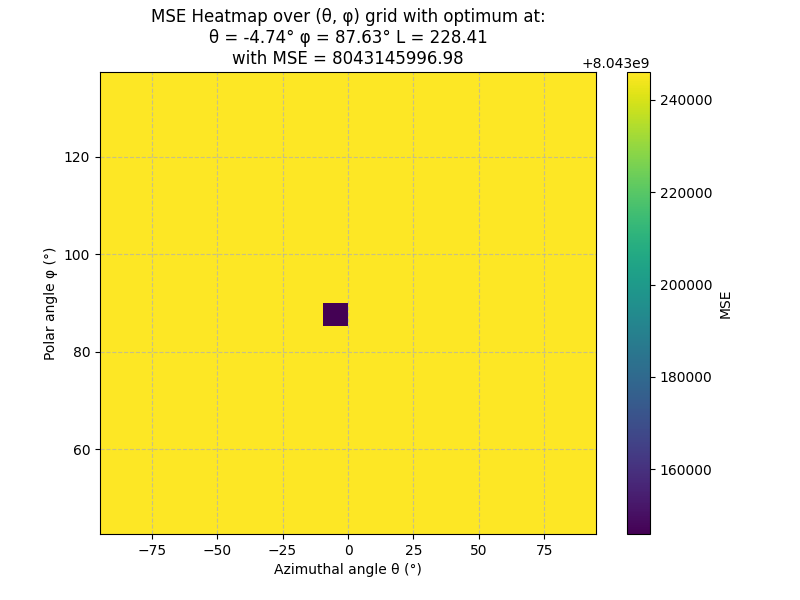

In [450]:
data_path = r"/home/loriskeller/Documents/Master Project/Patient data/patient_data_complete/Patient_structures_clean"
output_path = r"/home/loriskeller/Documents/Master Project/Results/12.05.25/Tester"
MSP_pipeline(data_path, output_path, structure_names=["Image", "GTVp", "Mandible", "Spinal Cord", "Body"], HU_range=[300, 2500],
             slice_axis=2, slice_range=None, azimuthal=(0, 90), polar=(90, 45), initialization_steps=20, delta=300, widget=True)
